In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(0)

n = 6000

In [4]:
df = pd.DataFrame({
    "claim_id": range(1, n + 1),
    "claim_amount": np.random.gamma(2, 500, n).round(2),
    "claim_type": np.random.choice(
        ["emergency", "outpatient", "inpatient", "pharmacy"], n
    ),
    "days_to_submit": np.random.randint(0, 60, n),
    "provider_type": np.random.choice(
        ["hospital", "clinic", "private_practice"], n
    ),
    "diagnosis_group": np.random.choice(
        ["cardio", "ortho", "general", "neuro"], n
    )
})

In [5]:
df.head()

,claim_id,claim_amount,claim_type,days_to_submit,provider_type,diagnosis_group
0,1,206.23,pharmacy,32,clinic,cardio
1,2,2870.71,outpatient,33,clinic,neuro
2,3,389.90,outpatient,53,private_practice,ortho
3,4,393.73,inpatient,40,private_practice,cardio
4,5,347.84,emergency,12,private_practice,neuro


In [6]:
df["denied"] = (
    (df["days_to_submit"] > 30).astype(int) |
    (df["claim_amount"] > 3000).astype(int) |
    ((df["claim_type"] == "pharmacy") & (df["claim_amount"] > 1500)).astype(int)
)

In [7]:
df.shape

(6000, 7)

In [8]:
df["denied"].value_counts()

denied
1    3161
0    2839
Name: count, dtype: int64

In [9]:
df["denied"].value_counts(normalize=True)

denied
1    0.526833
0    0.473167
Name: proportion, dtype: float64

In [10]:
df.groupby("claim_type")["denied"].mean()

claim_type
emergency     0.503329
inpatient     0.496210
outpatient    0.523256
pharmacy      0.583722
Name: denied, dtype: float64

In [11]:
df.groupby(df["days_to_submit"] > 30)["denied"].mean()

days_to_submit
False    0.064888
True     1.000000
Name: denied, dtype: float64

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [13]:
X = df.drop(columns=["denied", "claim_id"])
y = df["denied"]

In [14]:
cat_cols = ["claim_type", "provider_type", "diagnosis_group"]
num_cols = ["claim_amount", "days_to_submit"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

In [15]:
model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['claim_type',
                                                   'provider_type',
                                                   'diagnosis_group']),
                                                 ('num', 'passthrough',
                                                  ['claim_amount',
                                                   'days_to_submit'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [17]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.980283563897257

In [18]:
feature_names = model.named_steps["prep"].get_feature_names_out()
coefs = model.named_steps["clf"].coef_[0]

importance = pd.Series(coefs, index=feature_names).sort_values()
importance.tail(10)

cat__provider_type_clinic             -0.089223
cat__diagnosis_group_neuro            -0.069095
cat__diagnosis_group_ortho            -0.037646
num__claim_amount                      0.001798
cat__provider_type_private_practice    0.027395
cat__diagnosis_group_cardio            0.039084
cat__provider_type_hospital            0.061723
cat__diagnosis_group_general           0.067552
num__days_to_submit                    0.328483
cat__claim_type_pharmacy               1.179494
dtype: float64

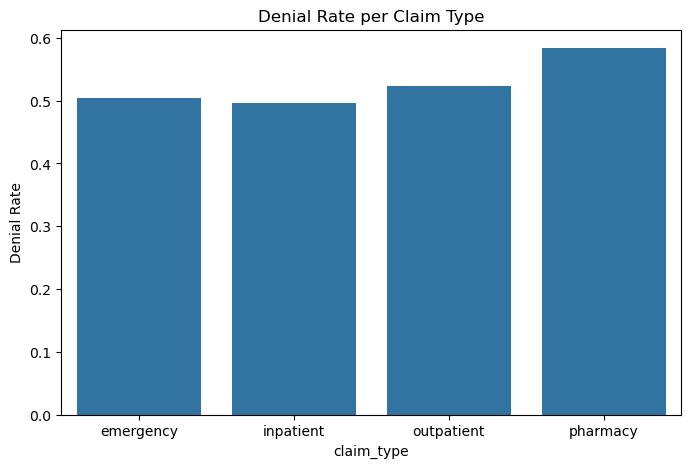

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=df.groupby("claim_type")["denied"].mean().index,
            y=df.groupby("claim_type")["denied"].mean().values)
plt.ylabel("Denial Rate")
plt.title("Denial Rate per Claim Type")
plt.show()

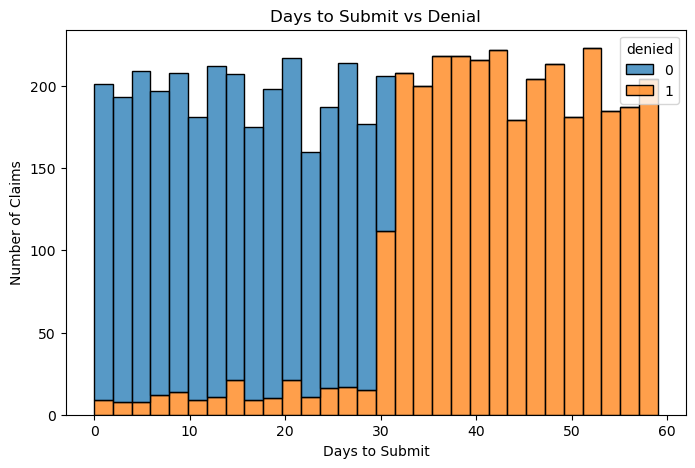

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df, x="days_to_submit", hue="denied", multiple="stack", bins=30)
plt.title("Days to Submit vs Denial")
plt.xlabel("Days to Submit")
plt.ylabel("Number of Claims")
plt.show()